In [34]:
import os
import sys
from pathlib import Path
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage.measure import regionprops_table
from skimage import exposure, measure, util

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [37]:
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [38]:
# Define image and masks folder
info_csv = data_meta / "info_combined.csv"

df = pd.read_csv(info_csv)

In [39]:
df=df[df.Location.isin([1,2])]

# Get imags

In [40]:
def get_location(df, location):
    imgs_path = []
    markers = []
    df = df[df.Location == location]
    for row in df.itertuples():
        if row.Marker == 'Hoeschst' and row.Cycle != 'Cycle1':
            continue
        imgs_path.append(row.Path)
        markers.append(row.Marker)
    return imgs_path, markers

def background_correction(
    img, filtersize=1025, sigma=256
):
    """Function to perform background substraction for image using gaussian blurr of original image

    Args:
        df (pd DataFrame) : info dataframe for all images
        filtersize (int) : filter size of gaussian kernel
        sigma (int) : sigma of guassian blurr
        folder (str) : folder to save corrected images
        save (bool) : bool to save the image
        show (bool) : bool to show corrected image and gaussian blur of original image

    Returns:
        None
    """

    gaussianImg = cv2.GaussianBlur(img, (filtersize, filtersize), sigma)
    img_corrected = cv2.subtract(img, gaussianImg)
    return img_corrected

def get_region_props(img, cell, nuclei, cyto, marker, location, prop):
    """
    Get regionprops from masked region
    """
    cell_props = regionprops_table(cell, img, properties=prop)
    nuclei_props = regionprops_table(nuclei, img, properties=prop)
    cyto_props = regionprops_table(cyto, img, properties=prop)

    props = [cell_props, nuclei_props, cyto_props]
    prefix = ["Cell_", "Nuclei_", "Cyto_"]
    df_marker = pd.concat(
        [pd.DataFrame(prop).add_prefix(prefix[idx]) for idx, prop in enumerate(props)],
        axis=1,
    )
    df_marker["Marker"] = marker
    df_marker["Location"] = location
    df_marker["Id"] = regionprops_table(cell, properties=["label"])["label"]

    return df_marker

def measure_prop_bleach(df, masks):
    appended_data_intensity = []
    appended_data_morphology = []

    # Get each segmented cell region with corresponding nuclei and cell
    for idx, location in enumerate(masks.keys()):
        # Get cell masks
        mask_cyto = masks[location]["cyto"]
        mask_nuclei = masks[location]["nuclei"]
        cell, nuclei, cyto = my_utils.qc_nuclei(mask_cyto, mask_nuclei)
        
        # Get images
        imgs, markers = get_location(df, int(location))
        for idx, img_path in enumerate(imgs):
            img = skimage.io.imread(img_path)
            img = background_correction(img)
            # p2, p98 = np.percentile(img, (0, 100))
            # img = exposure.rescale_intensity(img, in_range=(p2, p98), out_range=(0,255))
            img = img[:cell.shape[0], :cell.shape[1]]
            df_marker = get_region_props(
                img, cell, nuclei, cyto, markers[idx], location, ["mean_intensity"]
            )
            df_marker['Cell_mean_intensity'] = df_marker['Cell_mean_intensity'] 
            df_marker['Cell_mean_intensity'].clip(lower=0, upper=1000, inplace=True)
            appended_data_intensity.append(df_marker)


    df_prop_intensity = pd.concat(appended_data_intensity, ignore_index=True)
    df_prop_intensity = df_prop_intensity.sort_values(
        by=["Location", "Id"]
    ).reset_index(drop=True)

    
    return df_prop_intensity

In [41]:
masks = my_utils.get_masks(data_mask)

In [42]:
df_before = df[df.After_bleach==False]
df_after = df[df.After_bleach==True]

In [43]:
df_prop_i = measure_prop_bleach(df_before, masks)

In [44]:
df_prop_i_after = measure_prop_bleach(df_after, masks)

# Comparision on per cell intensity 

In [45]:
df_prop_i['Condition'] = 'Normal'
df_prop_i_after['Condition'] = 'After Bleach'
df_prop_combined = pd.concat([df_prop_i, df_prop_i_after])

In [46]:
df_prop_combined = df_prop_combined[~df_prop_combined.Marker.isin(['B-actin', 'Hoeschst'])]

In [47]:
df_prop_combined

,Cell_mean_intensity,Nuclei_mean_intensity,Cyto_mean_intensity,Marker,Location,Id,Condition
1,192.061215,358.844662,100.317028,p-EGFR,1,1,Normal
2,1000.000000,2552.825273,462.118916,Concanavalin A,1,1,Normal
3,28.828456,32.024961,27.070124,PCNA,1,1,Normal
5,265.403432,532.342322,118.565772,Phalloidin,1,1,Normal
6,1000.000000,1549.351237,1425.838789,WGA,1,1,Normal
...,...,...,...,...,...,...,...
2673,2.329503,2.190589,2.408753,B-tubin,2,52,After Bleach
2674,2.314708,1.557533,2.746673,Cyclin D1,2,52,After Bleach
2675,5.599684,4.296560,6.343109,H3k27me3-488,2,52,After Bleach
2676,3.075840,3.079083,3.073991,H3k4me3-647,2,52,After Bleach


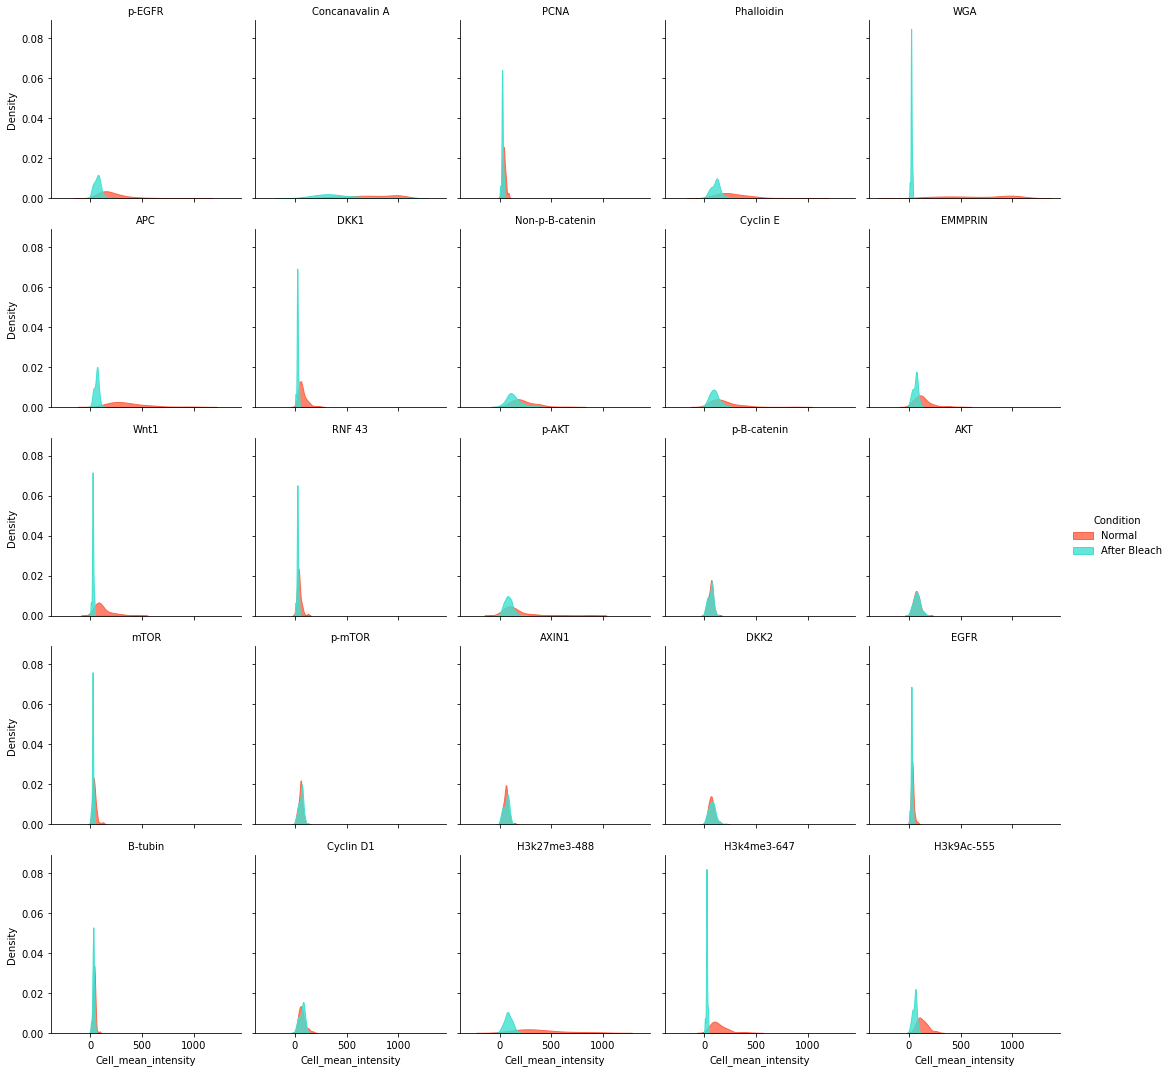

In [48]:
import seaborn as sns 

g = sns.FacetGrid(df_prop_combined, col='Marker', col_wrap=5, hue='Condition', palette=['tomato', 'turquoise'])
g.map(sns.kdeplot, "Cell_mean_intensity", fill=True, common_norm=False, alpha=0.8)
g = g.set_titles("{col_name}")
g.add_legend()

In [49]:
df_prop_cell = df_prop_combined.drop(['Nuclei_mean_intensity', 'Cyto_mean_intensity'], axis=1)
df_prop_cell.head()

,Cell_mean_intensity,Marker,Location,Id,Condition
1,192.061215,p-EGFR,1,1,Normal
2,1000.000000,Concanavalin A,1,1,Normal
3,28.828456,PCNA,1,1,Normal
5,265.403432,Phalloidin,1,1,Normal
6,1000.000000,WGA,1,1,Normal


In [50]:
df_long = df_prop_cell.melt(id_vars=['Marker', 'Condition'], value_vars='Cell_mean_intensity', value_name='Intensity')
df_long.head()

,Marker,Condition,variable,Intensity
0,p-EGFR,Normal,Cell_mean_intensity,192.061215
1,Concanavalin A,Normal,Cell_mean_intensity,1000.000000
2,PCNA,Normal,Cell_mean_intensity,28.828456
3,Phalloidin,Normal,Cell_mean_intensity,265.403432
4,WGA,Normal,Cell_mean_intensity,1000.000000


In [51]:
df_long = df_long[~df_long.Marker.isin(['Concanavalin A', 'Phalloidin', 'WGA'])]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-AKT_Normal vs. p-AKT_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:2.082e-06 U_stat=7.335e+03
p-B-catenin_Normal vs. p-B-catenin_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:9.422e-01 U_stat=5.336e+03
AKT_Normal vs. AKT_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:8.115e-01 U_stat=5.407e+03
mTOR_Normal vs. mTOR_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:3.724e-13 U_stat=8.413e+03
p-mTOR_Normal vs. p-mTOR_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:5.586e-02 U_stat=4.486e+03
AXIN1_Normal vs. AXIN1_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-01 U_stat=4.641e+03
DKK2_Normal vs. DKK2_After Bleach: Mann-Whitney-Wilcoxon test two-sided, P_val:3.833e-01 U_stat=4.931e+03
EGFR_Normal vs. EGFR_After Bleach: Mann-Whitney-Wilcoxon 

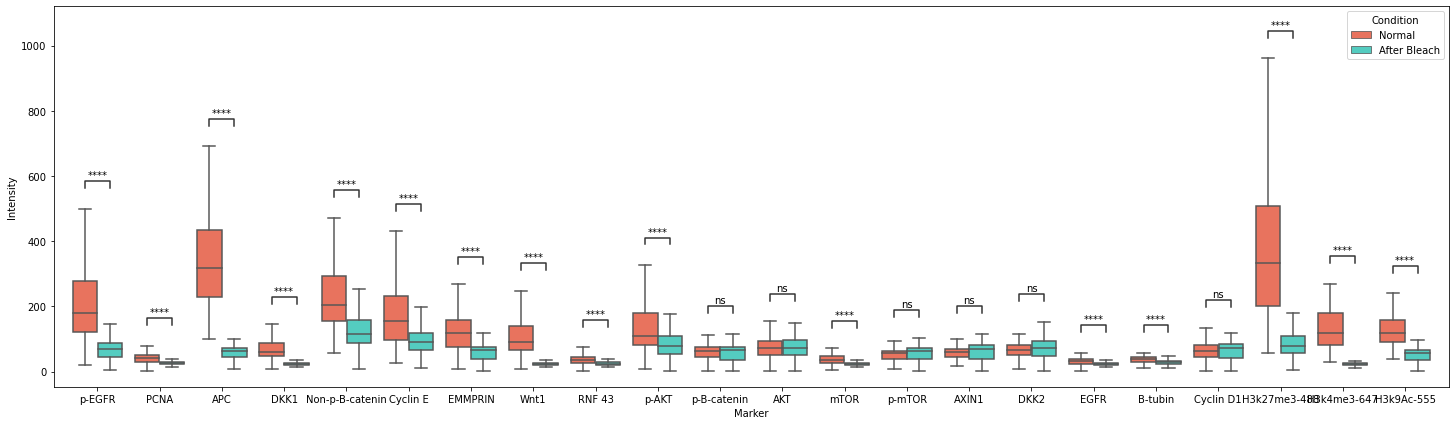

In [52]:
from statannotations.Annotator import Annotator

fig, ax = plt.subplots(figsize=(25,7))
g = sns.boxplot(x="Marker", y="Intensity", hue="Condition",
                    data=df_long, palette=['tomato', 'turquoise'], showfliers=False, ax=ax)

pairs = [((marker, 'Normal'), (marker, 'After Bleach')) for marker in df_long.Marker.unique()]
annot = Annotator(g, pairs, data=df_long, x="Marker", y="Intensity", hue="Condition",)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()
